<a href="https://colab.research.google.com/github/julwdo/NLP-project/blob/main/NLP_Project_JW_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.6f}".format)

In [107]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/TwiBot-22_Processed"

enriched_user_features = pd.read_parquet(f"{path}/enriched_user_features.parquet", engine='pyarrow')

In [109]:
n_rows, n_columns = enriched_user_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 314813 rows and 58 columns.


In [110]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,tweets_last20_concatenated_text,tweets_last20_reply_fraction,tweets_last20_num_distinct_langs,tweets_last20_sensitive_fraction,tweets_last20_avg_likes,tweets_last20_avg_quotes,tweets_last20_avg_replies,tweets_last20_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,230933321,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,human,Great thread on building your startup. 40+ les...,0.200000,1,0.000000,0.400000,0.000000,0.000000,976.000000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,230785860,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,human,"RT <USER>: ""I spoke to President Putin this mo...",0.000000,2,0.000000,0.900000,NaN,NaN,71.000000


In [111]:
# Check for missing values
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                           Missing Count  Missing Percentage
tweets_last20_avg_quotes          177868           56.499573
tweets_last20_avg_replies         177868           56.499573


In [113]:
enriched_user_features.dropna(axis=1, inplace=True)  # drop columns with any NaNs

In [115]:
# Check for missing values again
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [116]:
# Check and handle duplicate rows
duplicates = enriched_user_features.duplicated().sum()
if duplicates > 0:
    print(f"Warning: The dataset contains {duplicates} duplicate rows.")
    enriched_user_features = enriched_user_features.drop_duplicates()
    print(f"\n{duplicates} duplicate rows have been dropped. The dataset now has {enriched_user_features.shape[0]} rows.")
else:
    print("No duplicate rows found in the dataset.")

No duplicate rows found in the dataset.


In [117]:
# Cast label column: 1 if "bot", 0 if "human"
enriched_user_features['label'] = enriched_user_features['label'].map({'human': 0, 'bot': 1})

In [118]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,tweets_last20_concatenated_text,tweets_last20_reply_fraction,tweets_last20_num_distinct_langs,tweets_last20_sensitive_fraction,tweets_last20_avg_likes,tweets_last20_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,230933321,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,0,Great thread on building your startup. 40+ les...,0.200000,1,0.000000,0.400000,976.000000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,230785860,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,0,"RT <USER>: ""I spoke to President Putin this mo...",0.000000,2,0.000000,0.900000,71.000000


In [119]:
# Count human and bot accounts
human_count = (enriched_user_features['label'] == 0).sum()
bot_count = n_rows - human_count

human_pct = human_count / n_rows * 100
bot_pct = bot_count / n_rows * 100

print(f"Number of human accounts: {human_count} ({human_pct:.2f}%)")
print(f"Number of bot accounts: {bot_count} ({bot_pct:.2f}%)")

Number of human accounts: 291089 (92.46%)
Number of bot accounts: 23724 (7.54%)


In [130]:
# Separate features (X) and target (y)
X = enriched_user_features.drop(columns=['id', 'label'])
y = enriched_user_features['label']

In [132]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64'), dtype('O'), dtype('bool'),
       dtype('float32'), dtype('int64')], dtype=object)

In [141]:
n_features = X.shape[1]

num_cols = X.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns
text_cols = X.select_dtypes(include=['O']).columns

num_bool_cols = num_cols.append(bool_cols)

print(f"There are {n_features} features: {len(num_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 54 features: 42 numeric, 10 boolean, 2 text/object.


In [142]:
from sklearn.model_selection import train_test_split

# Train, validation, test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

val_size = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
    )

In [143]:
def report_split(y, split_name):
    n = len(y)
    pct = n / len(enriched_user_features) * 100
    class_counts = y.value_counts()
    class_pct = y.value_counts(normalize=True) * 100

    print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
    for cls in class_counts.index:
        print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
    print("-" * 40)

report_split(y_train, "Training")
report_split(y_val, "Validation")
report_split(y_test, "Test")

Training set: 220368 rows (70.00% of dataset)
  Class 0: 203761 rows (92.46%)
  Class 1: 16607 rows (7.54%)
----------------------------------------
Validation set: 62963 rows (20.00% of dataset)
  Class 0: 58218 rows (92.46%)
  Class 1: 4745 rows (7.54%)
----------------------------------------
Test set: 31482 rows (10.00% of dataset)
  Class 0: 29110 rows (92.47%)
  Class 1: 2372 rows (7.53%)
----------------------------------------


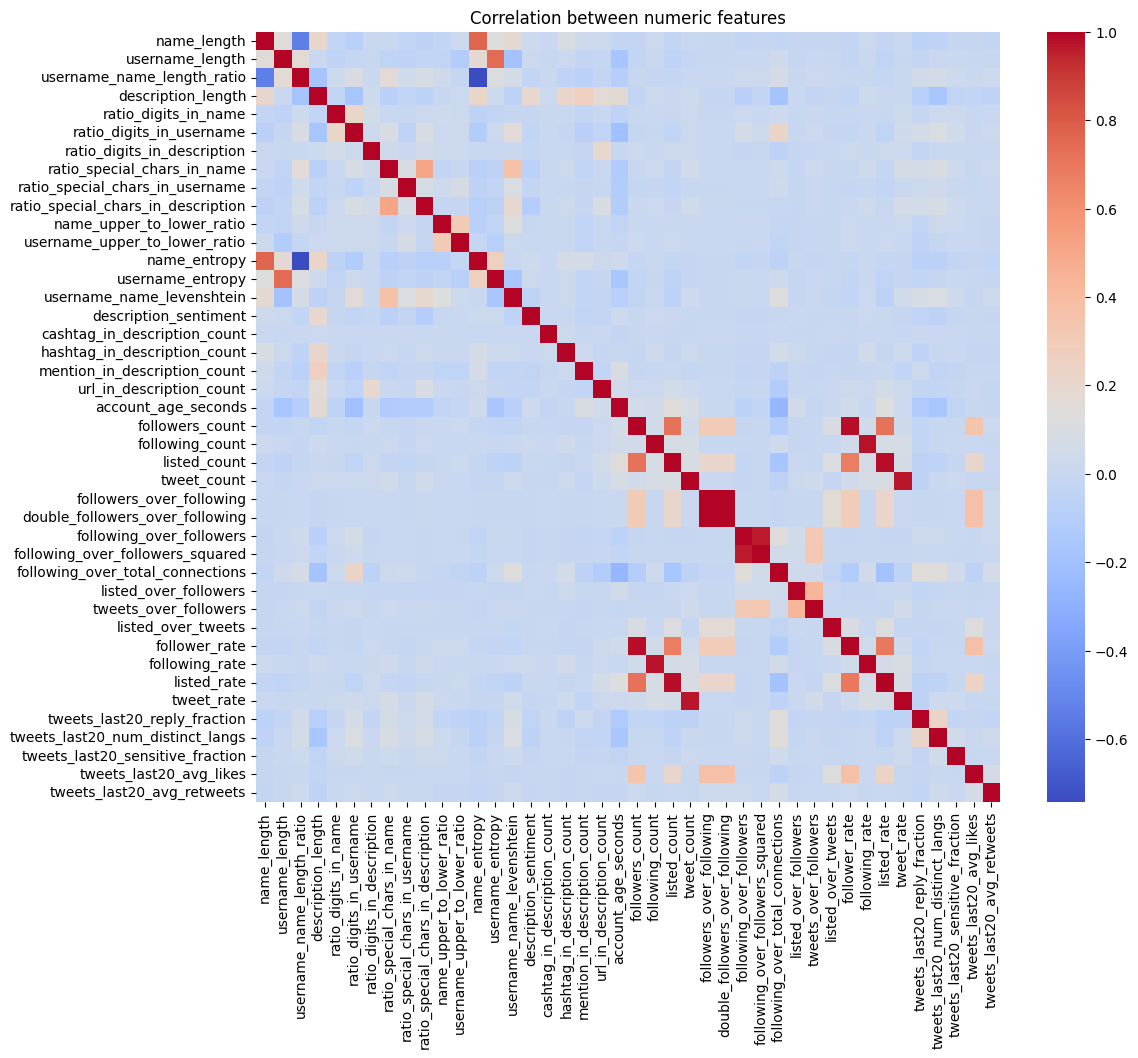

In [144]:
# Check pairwise correlations between numeric features
corr_matrix = X_train[num_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

In [145]:
threshold = 0.8
high_corr = [(col1, col2, corr_matrix.loc[col1, col2])
             for col1 in num_cols for col2 in num_cols
             if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > threshold]

print("Highly correlated pairs (>|0.8|):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} - {col2}: {corr_val:.2f}")

Highly correlated pairs (>|0.8|):
followers_count - follower_rate: 0.98
following_count - following_rate: 0.98
listed_count - listed_rate: 0.99
tweet_count - tweet_rate: 0.97
followers_over_following - double_followers_over_following: 1.00
double_followers_over_following - followers_over_following: 1.00
following_over_followers - following_over_followers_squared: 0.96
following_over_followers_squared - following_over_followers: 0.96
follower_rate - followers_count: 0.98
following_rate - following_count: 0.98
listed_rate - listed_count: 0.99
tweet_rate - tweet_count: 0.97


In [146]:
# Check for numeric/boolean features with low variance
variances = X_train[num_bool_cols].var()

low_variance = variances[variances < 0.01].sort_values()

print("Features with variance < 0.01:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.01:
has_username: 0.000000
listed_rate: 0.000000
following_rate: 0.000000
tweet_rate: 0.000000
follower_rate: 0.000004
has_name: 0.000036
ratio_digits_in_description: 0.000837
has_bot_word_in_name: 0.000866
ratio_digits_in_name: 0.001484
has_bot_word_in_description: 0.001816
is_protected: 0.001957
ratio_special_chars_in_username: 0.002009
tweets_last20_sensitive_fraction: 0.004085


In [147]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("num_bool_pipeline", num_bool_pipeline, num_bool_cols)
    ],
                                 remainder="passthrough")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/val/test sets
X_train_selected = preprocessor.transform(X_train)
X_val_selected = preprocessor.transform(X_val)
X_test_selected = preprocessor.transform(X_test)

In [167]:
num_bool_pipeline_fitted = preprocessor.named_transformers_['num_bool_pipeline']

var_mask = num_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = num_bool_cols[var_mask]

sfm = num_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
selected_num_bool_cols = cols_after_var[model_mask]

passthrough_cols = [col for col in X_train.columns if col not in num_bool_cols]

all_selected_cols = list(selected_num_bool_cols) + passthrough_cols

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols)
X_val_selected_df = pd.DataFrame(X_val_selected, columns=all_selected_cols)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols)

In [168]:
X_train.head(2)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,tweets_last20_concatenated_text,tweets_last20_reply_fraction,tweets_last20_num_distinct_langs,tweets_last20_sensitive_fraction,tweets_last20_avg_likes,tweets_last20_avg_retweets
172472,15,9,0.600000,❤️ Jesus | Wealth Hacker® | 🇺🇸 #Veteran | 📖 So...,154,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.133333,0.000000,0.175325,0.833333,0.000000,3.506891,2.503258,0.666667,0.493900,0,3,4,0,False,True,534588250,32007,6076,1096,25942,5.267775,10.535550,0.189833,0.000006,0.159546,0.034243,0.810510,0.042248,0.000060,0.000011,0.000002,0.000049,Ask the Readers: Resources for Writing a Will?...,0.000000,1,0.000000,0.000000,0.000000
109997,10,7,0.700000,Assistant Professor of Political Science and D...,107,True,True,True,True,True,True,False,False,0.000000,0.000000,0.000000,0.000000,0.142857,0.084112,0.285714,0.000000,2.921928,2.235926,0.600000,0.000000,0,0,2,0,False,True,449868400,5903,822,114,552,7.181265,14.362530,0.139251,0.000024,0.122230,0.019312,0.093512,0.206522,0.000013,0.000002,0.000000,0.000001,<USER> Second! RT <USER>: NEW PAPER Do survey-...,0.450000,2,0.000000,2.950000,18.200000


In [169]:
X_train_selected_df.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,double_followers_over_following,following_over_followers,following_over_followers_squared,listed_over_followers,tweets_over_followers,listed_over_tweets,tweets_last20_num_distinct_langs,tweets_last20_avg_retweets,has_description,is_verified,description,tweets_last20_concatenated_text
0,15.000000,0.600000,154.000000,0.133333,0.175325,3.000000,534588250.000000,32007.000000,6076.000000,25942.000000,10.535550,0.189833,0.000006,0.034243,0.810510,0.042248,1.000000,0.000000,1.000000,1.000000,❤️ Jesus | Wealth Hacker® | 🇺🇸 #Veteran | 📖 So...,Ask the Readers: Resources for Writing a Will?...
1,10.000000,0.700000,107.000000,0.000000,0.084112,0.000000,449868400.000000,5903.000000,822.000000,552.000000,14.362530,0.139251,0.000024,0.019312,0.093512,0.206522,2.000000,18.200000,1.000000,1.000000,Assistant Professor of Political Science and D...,<USER> Second! RT <USER>: NEW PAPER Do survey-...


In [170]:
print("Selected numeric/boolean features:")
print(selected_num_bool_cols.tolist())

Selected numeric/boolean features:
['name_length', 'username_name_length_ratio', 'description_length', 'ratio_special_chars_in_name', 'ratio_special_chars_in_description', 'hashtag_in_description_count', 'account_age_seconds', 'followers_count', 'following_count', 'tweet_count', 'double_followers_over_following', 'following_over_followers', 'following_over_followers_squared', 'listed_over_followers', 'tweets_over_followers', 'listed_over_tweets', 'tweets_last20_num_distinct_langs', 'tweets_last20_avg_retweets', 'has_description', 'is_verified']


In [176]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": selected_num_bool_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                               feature  importance
7                      followers_count    0.498957
2                   description_length    0.131667
9                          tweet_count    0.109669
18                     has_description    0.065774
8                      following_count    0.063336
17          tweets_last20_avg_retweets    0.024732
19                         is_verified    0.021268
6                  account_age_seconds    0.018480
1           username_name_length_ratio    0.011609
4   ratio_special_chars_in_description    0.010642
3          ratio_special_chars_in_name    0.005981
5         hashtag_in_description_count    0.005610
13               listed_over_followers    0.004847
15                  listed_over_tweets    0.003723
11            following_over_followers    0.002895
16    tweets_last20_num_distinct_langs    0.002822
10     double_followers_over_following    0.002676
14               tweets_over_followers    0.002229
12    following_over_followers_